# MIA vs Overfitting

In this notebook we will study the effect of overfitting in MIA's performance, given a CNN model, CIFAR-10 dataset and a MIA framework that will perfrom the attacks for us.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import regularizers

# for image interpolation
import scipy.ndimage.interpolation as interpolation

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
!cp ../input/mia-v2 ./mia_v2 -r
from mia_v2.attack_model import *
from mia_v2.label_only import *
from mia_v2.shadow_models import *
from mia_v2.utilities import *
from mia_v2.wrappers import ConfidenceVectorAttack, LabelOnlyAttack

from tqdm import tqdm
import sys
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [2]:
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1e-4, patience=20)

In [3]:
def f_target(X_train, y_train, X_test, y_test, epochs=100):
  """
  Returns a trained target model, if test data are specified we will evaluate the model and print its accuracy
  """
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='tanh'))
  model.add(layers.MaxPooling2D((2, 2)))


  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='tanh'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.Adam(learning_rate=0.001)

  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  history = model.fit(X_train, y_train, 
                      epochs=epochs, 
                      validation_data=(X_test, y_test),
                      callbacks=[es]
                      )
  return model, history

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170508288/170498071 [==============================] - 7s 0us/step


In [5]:
print(f"We have {len(train_images)} train instances and {len(test_images)} test instances.")

We have 50000 train instances and 10000 test instances.


Let us give the attacker 10000 data points and let the rest of them be training-evaluation-testing datapoints for the target model.

In [6]:
attacker_images, attacker_labels = (test_images, test_labels)
N_SHADOWS = 5
D_SHADOW= 5000

In [7]:
def f_shadow():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.SGD(learning_rate=0.001, decay=1e-7)
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

In [8]:
attack = ConfidenceVectorAttack(None, (train_images, train_labels), 
                                  (attacker_images, attacker_labels), shadow_creator=f_shadow, attack_model_creator=cifar_10_f_attack_builder,
                                n_shadows=N_SHADOWS, D_shadow_size=D_SHADOW, verbose=True)
attack.perform_attack(shadow={'epochs':100, 'batch_size':64, 'callbacks':[es]})

2022-04-10 12:55:42.004510: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-04-10 12:55:42.703558: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
53/53 [==============================] - 3s 48ms/step - loss: 6.6055 - accuracy: 0.1069 - val_loss: 2.3216 - val_accuracy: 0.1218
Epoch 2/100
53/53 [==============================] - 2s 41ms/step - loss: 2.2740 - accuracy: 0.1406 - val_loss: 2.3062 - val_accuracy: 0.1327
Epoch 3/100
53/53 [==============================] - 2s 40ms/step - loss: 2.2005 - accuracy: 0.1749 - val_loss: 2.2100 - val_accuracy: 0.1648
Epoch 4/100
53/53 [==============================] - 2s 42ms/step - loss: 2.1461 - accuracy: 0.1967 - val_loss: 2.1730 - val_accuracy: 0.2018
Epoch 5/100
53/53 [==============================] - 3s 57ms/step - loss: 2.0895 - accuracy: 0.2233 - val_loss: 2.1000 - val_accuracy: 0.2382
Epoch 6/100
53/53 [==============================] - 2s 40ms/step - loss: 2.0199 - accuracy: 0.2675 - val_loss: 2.1356 - val_accuracy: 0.2145
Epoch 7/100
53/53 [==============================] - 3s 50ms/step - loss: 1.9755 - accuracy: 0.2869 - val_loss: 2.0322 - val_accuracy: 0.2727
Epoch 

Epoch 1/100
63/63 [==============================] - 12s 177ms/step - loss: 2.1302 - accuracy: 0.2350 - val_loss: 1.7935 - val_accuracy: 0.3419
Epoch 2/100
63/63 [==============================] - 9s 147ms/step - loss: 1.6831 - accuracy: 0.3945 - val_loss: 1.8588 - val_accuracy: 0.3147
Epoch 3/100
63/63 [==============================] - 9s 148ms/step - loss: 1.5256 - accuracy: 0.4560 - val_loss: 1.6939 - val_accuracy: 0.3832
Epoch 4/100
63/63 [==============================] - 11s 175ms/step - loss: 1.2955 - accuracy: 0.5345 - val_loss: 1.7018 - val_accuracy: 0.4034
Epoch 5/100
63/63 [==============================] - 9s 145ms/step - loss: 1.1152 - accuracy: 0.6200 - val_loss: 1.6722 - val_accuracy: 0.4245
Epoch 6/100
63/63 [==============================] - 9s 149ms/step - loss: 0.9281 - accuracy: 0.6955 - val_loss: 1.6994 - val_accuracy: 0.4205
Epoch 7/100
63/63 [==============================] - 11s 172ms/step - loss: 0.7145 - accuracy: 0.7895 - val_loss: 1.7169 - val_accuracy: 0.4

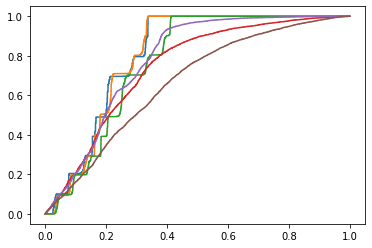

In [9]:
scores = []
history = []
model_vuln = []

for dataset_size in [2000, 2500, 5000, 7500, 10000, 20000]:
  X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, train_size=dataset_size)
  target_model, h = f_target(X_train, y_train, X_test, y_test, epochs=100)
  history.append(h)

  attack.target_model = target_model
  attack.target_dataset = X_train, y_train
  _score = attack.evaluate_attack()
  scores.append(_score)

  model_vuln.append(evaluate_model_vulnerability(target_model, (X_train, y_train), (attacker_images, attacker_labels), 'tf', batch_size=256))


In [10]:
dt_size = [2000, 2500, 5000, 7500, 10000, 20000]

Text(0, 0.5, 'Model Vulnerability')

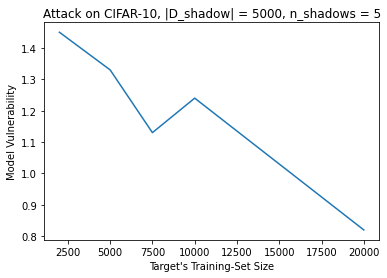

In [11]:
plt.plot(dt_size, model_vuln)
plt.title(f'Attack on CIFAR-10, |D_shadow| = {D_SHADOW}, n_shadows = {N_SHADOWS}')
plt.xlabel('Target\'s Training-Set Size')
plt.ylabel('Model Vulnerability')

Text(0, 0.5, 'AUC Score')

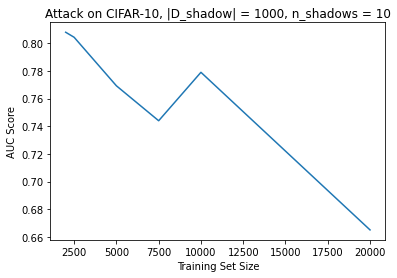

In [12]:
auc_scores = [items[1] for items in scores]

plt.plot(dt_size, auc_scores)
plt.title('Attack on CIFAR-10, |D_shadow| = 1000, n_shadows = 10')
plt.xlabel('Training Set Size')
plt.ylabel('AUC Score')

Text(0, 0.5, 'Recall Score')

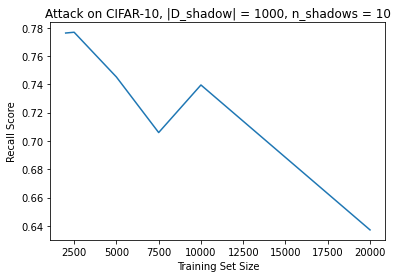

In [13]:
recall_scores = [items[0]['macro avg']['recall'] for items in scores]

plt.plot(dt_size, recall_scores)
plt.title('Attack on CIFAR-10, |D_shadow| = 1000, n_shadows = 10')
plt.xlabel('Training Set Size')
plt.ylabel('Recall Score')

Text(0, 0.5, 'Precision Score')

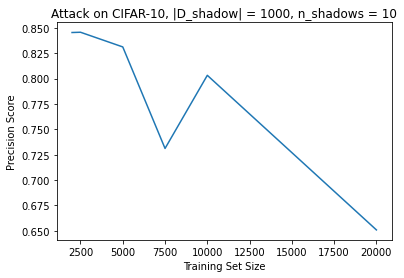

In [14]:
precision_scores = [items[0]['macro avg']['precision'] for items in scores]

plt.plot(dt_size, precision_scores)

plt.title('Attack on CIFAR-10, |D_shadow| = 1000, n_shadows = 10')
plt.xlabel('Training Set Size')
plt.ylabel('Precision Score')

Text(0, 0.5, 'Accuracy Score')

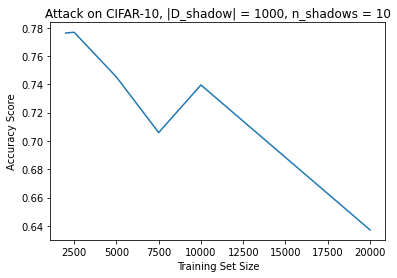

In [15]:
accuracy_scores = [items[0]['accuracy'] for items in scores]

plt.plot(dt_size, accuracy_scores)

plt.title('Attack on CIFAR-10, |D_shadow| = 1000, n_shadows = 10')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')